# Zeta Disease Prediction

### Importing packages

In [1]:
# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler

# Machine learning
import catboost
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import confusion_matrix

# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,roc_curve, auc

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

# for saving model
import pickle

### Reading & Processing data

In [2]:
train = pd.read_csv("2021-01-21_zeta-disease_training-data_dsi-take-home-challenge.csv")
train.head()
train.shape

(800, 9)

In [3]:
#copying data_raw to another data frame
data = pd.DataFrame.copy(train)
data.head(10)

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0
5,49,158,27.0,80,0,0.3218,0,2,1
6,20,154,27.8,64,116,0.5168,53,0,0
7,37,167,34.5,88,145,0.4658,54,1,1
8,21,162,34.8,80,132,0.2798,75,1,0
9,19,186,31.2,70,0,1.2448,0,4,1


In [4]:
# creating list of categorical columns, numerical columns, continous columns and target
categorical_columns = [features for features in data.columns if data[features].dtypes == "O"]
print("Categorical freatures are",len(categorical_columns),"numbers")
numerical_columns = [features for features in data.columns if data[features].dtypes != "O"]
print("Numerical freatures are",len(numerical_columns),"numbers")
target = ["zeta_disease"]
print("Target variable is zeta_disease")

Categorical freatures are 0 numbers
Numerical freatures are 9 numbers
Target variable is zeta_disease


In [5]:
# Select duplicate rows except first occurrence based on all columns
duplicateRows = data[data.duplicated()]
 
print("There are ",len(duplicateRows), "Duplicate Rows. Need to delete them from dataset.")

There are  5 Duplicate Rows. Need to delete them from dataset.


In [6]:
data = data.drop_duplicates(keep="first")
data.shape

(795, 9)

In [7]:
# checking for missing values
features_with_na = [features for features in data.columns if data[features].isnull().sum()>0]

for feature in features_with_na:
    print(feature, "has", data[feature].isnull().sum(), "missing values")

No missing values in dataset

### EDA

In [8]:
# Looking into numerical columns in dataset
for feature in data.columns:
    print("="*10, feature)
    print(data[feature].describe())   

========== age
count    795.000000
mean      30.636478
std       12.861397
min       18.000000
25%       21.000000
50%       26.000000
75%       38.000000
max      109.000000
Name: age, dtype: float64
========== weight
count    795.000000
mean     172.376101
std       31.686964
min       94.000000
25%      150.000000
50%      167.000000
75%      192.000000
max      308.000000
Name: weight, dtype: float64
========== bmi
count    795.000000
mean      32.230566
std        8.564706
min        0.000000
25%       27.300000
50%       32.200000
75%       36.600000
max       86.100000
Name: bmi, dtype: float64
========== blood_pressure
count    795.000000
mean      69.567296
std       19.922177
min        0.000000
25%       62.000000
50%       72.000000
75%       80.000000
max      157.000000
Name: blood_pressure, dtype: float64
========== insulin_test
count     795.000000
mean       85.905660
std       126.687381
min         0.000000
25%         0.000000
50%        45.000000
75%       130.0000

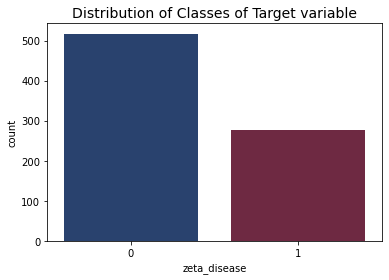

In [10]:
# Cheking the distribution of the target variable (Balanced data or Unbalanced data)
colors3=["#1d3f7a", "#7a1d3f"]
sns.countplot('zeta_disease', data=data, palette=colors3)
plt.title('Distribution of Classes of Target variable', fontsize=14)
plt.show()

This plot clearly shows that the distribution of output classes are balanced as ratio of data is appraximately 1:3

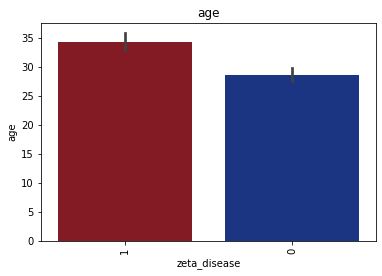

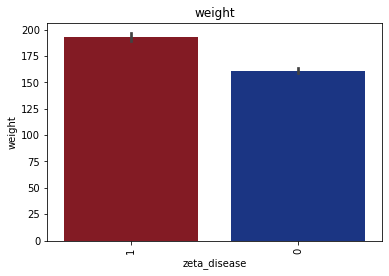

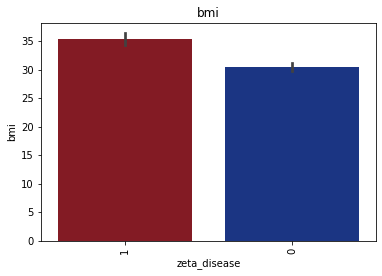

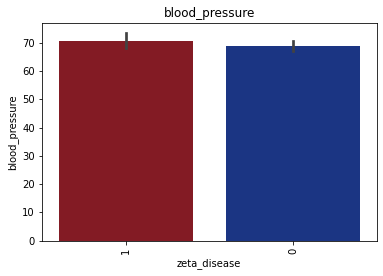

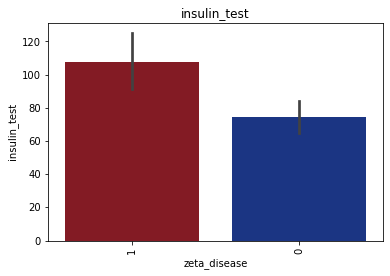

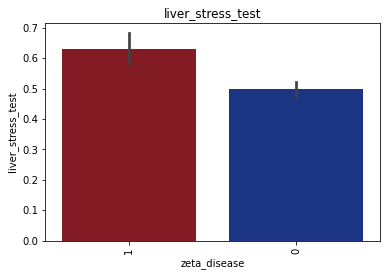

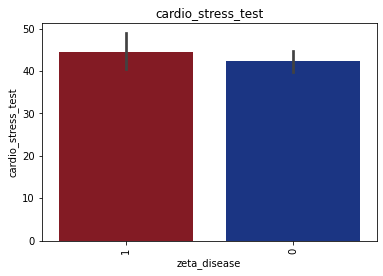

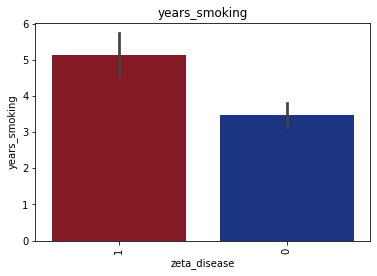

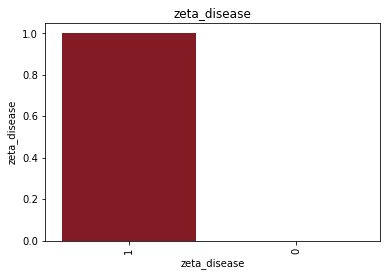

In [11]:
# checking relationship between numerical variables and target

for feature in data.columns:
    data_EDA=data.copy()
    colors1=["#940a16","#0a2d94"]
    sns.barplot(x="zeta_disease", y=feature, data=data_EDA, order=[1,0], palette=colors1)
    plt.xlabel('zeta_disease')
    plt.xticks(rotation=90)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

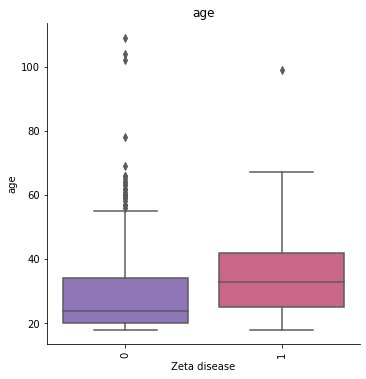

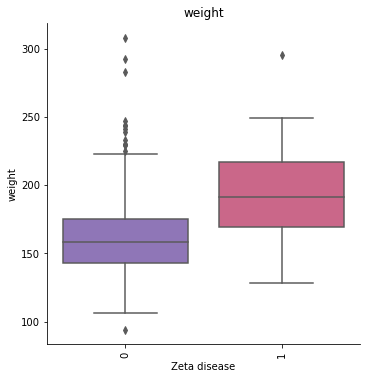

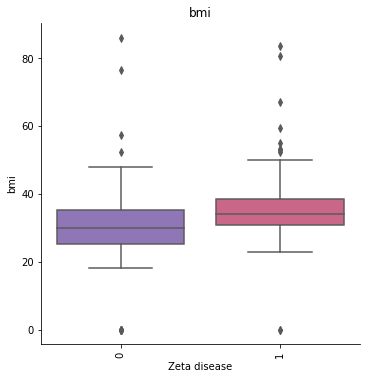

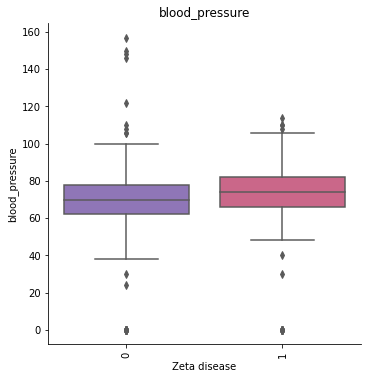

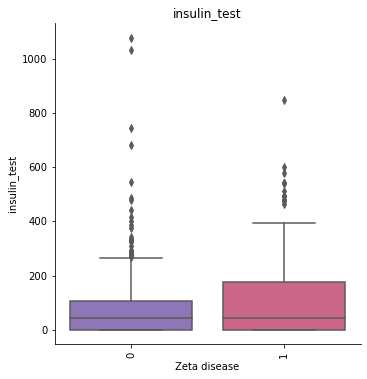

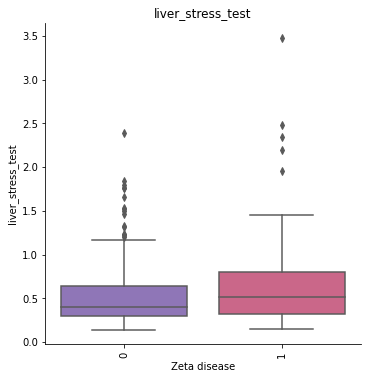

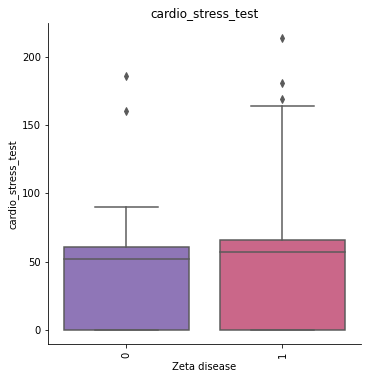

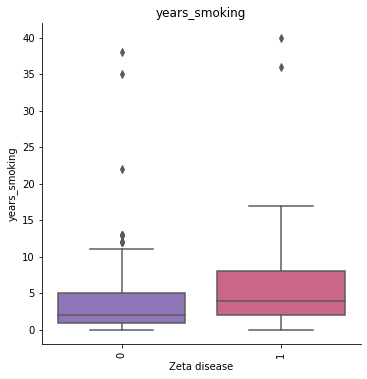

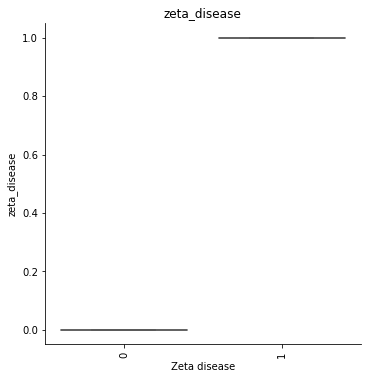

In [12]:
# Box plots plots for Continous variables vs Fraud
for feature in data.columns:
    data_EDA=data.copy()
    colors2 = ["#8c6bc2","#db5684"]
    sns.factorplot(y=feature, x="zeta_disease", data=data_EDA, kind="box", palette=colors2)
    plt.xlabel('Zeta disease')
    plt.xticks(rotation=90)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

#### Insights of EDA:

* There are all numeric variables as dependent variables. Not need encoding in preprocess of data.
* The data is balanced.
* Age, BMI, Weight are strongly co-related to Target variable.
* There many outliers in Insulin test and Liver test variables. If the accuracy is less, we can delete outliers from these variables to increase accuracy as part of deep analysis.

### Data preparation for Model Building

In [13]:
# Train test split
x = pd.DataFrame.copy(data)
y = x.pop('zeta_disease')
print(x.shape, y.shape)

(795, 8) (795,)


In [14]:
for feature in x.columns:
    std_scaler = StandardScaler()
    x[feature] = std_scaler.fit_transform(x[feature].values.reshape(-1,1))

In [15]:
x.head(10)

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking
0,1.817705,0.524959,-0.599413,0.524003,-0.678519,2.759593,-1.413122,1.423717
1,-0.594126,-0.706606,0.732469,-0.078720,-0.117731,-0.451050,0.391562,-0.492651
2,1.273098,0.430223,-0.272284,1.026272,-0.678519,-0.778725,-1.413122,0.705079
3,-0.983131,-0.706606,-0.167136,0.021733,7.480544,0.333646,0.424374,-0.971743
4,-0.516325,-0.390820,0.019795,0.222641,0.308783,0.623955,0.522811,-0.492651
5,1.428700,-0.453977,-0.611096,0.524003,-0.678519,-0.637882,-1.413122,-0.492651
6,-0.827529,-0.580291,-0.517631,-0.279628,0.237698,-0.077385,0.325937,-0.971743
7,0.495088,-0.169770,0.265142,0.925818,0.466752,-0.223976,0.358749,-0.732197
8,-0.749728,-0.327663,0.300191,0.524003,0.364072,-0.758604,1.047810,-0.732197
9,-0.905330,0.430223,-0.120403,0.021733,-0.678519,2.015138,-1.413122,-0.013559


In [16]:
y = pd.DataFrame(y)
y.head(10)

,zeta_disease
0,0
1,0
2,0
3,0
4,0
5,1
6,0
7,1
8,0
9,1


In [17]:
# Our data is already scaled we should split our training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state =42)

In [18]:
# Turn the values into an array for feeding the classification algorithms.
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values

### Model Building 

In [19]:
# Let's implement simple classifiers
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Naive & Bayes" : GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "Support Vector Classifier": SVC(),
    "Gradient Boosting classifier": GradientBoostingClassifier()
}

In [20]:
for key, classifier in classifiers.items():
    classifier.fit(x_train, y_train)
    training_score = cross_val_score(classifier, x_train, y_train, cv=10)
    print("Classifier: ", classifier.__class__.__name__, "has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")


Classifier:  LogisticRegression has a training score of 77.0 % accuracy score
Classifier:  KNeighborsClassifier has a training score of 72.0 % accuracy score
Classifier:  GaussianNB has a training score of 76.0 % accuracy score
Classifier:  DecisionTreeClassifier has a training score of 70.0 % accuracy score
Classifier:  RandomForestClassifier has a training score of 78.0 % accuracy score
Classifier:  SVC has a training score of 77.0 % accuracy score
Classifier:  GradientBoostingClassifier has a training score of 76.0 % accuracy score


In [21]:
# Use GridSearchCV to find the best parameters.
# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(x_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

# KNN
knears_params = {"n_neighbors": list(range(2,10,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(x_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# GNB
gnb_params = {}
grid_gnb = GridSearchCV(GaussianNB(), gnb_params)
grid_gnb.fit(x_train, y_train)
# GNB best estimator
gnb = grid_gnb.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"],"splitter":["best","random"]}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(x_train, y_train)
# tree best estimator
tree_clf = grid_tree.best_estimator_

# RandomForest Classifier
rfc_params = {"n_estimators":list(range(2,100,1)), "criterion":["gini", "entropy"]}
grid_rfc = GridSearchCV(RandomForestClassifier(), rfc_params)
grid_rfc.fit(x_train, y_train)
# tree best estimator
rfc = grid_rfc.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(x_train, y_train)
# SVC best estimator
svc = grid_svc.best_estimator_

# Gradient Boosting Classifier
gbc_params = {"loss":["deviance", "exponential"], "n_estimators":list(range(2,100,1))}
grid_gbc = GridSearchCV(GradientBoostingClassifier(), gbc_params)
grid_gbc.fit(x_train, y_train)
# tree best estimator
gbc = grid_gbc.best_estimator_

In [22]:
log_reg_score = cross_val_score(log_reg, x_train, y_train, cv=10)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, x_train, y_train, cv=10)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

gnb_score = cross_val_score(gnb, x_train, y_train, cv=10)
print('GuassianNB Cross Validation Score', round(gnb_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, x_train, y_train, cv=10)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

rfc_score = cross_val_score(rfc, x_train, y_train, cv=10)
print('Random Forest Classifier Cross Validation Score', round(rfc_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, x_train, y_train, cv=10)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

gbc_score = cross_val_score(gbc, x_train, y_train, cv=10)
print('Gradient Boosting Classifier Cross Validation Score', round(gbc_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  77.69%
Knears Neighbors Cross Validation Score 73.15%
GuassianNB Cross Validation Score 75.83%
DecisionTree Classifier Cross Validation Score 72.65%
Random Forest Classifier Cross Validation Score 77.84%
Support Vector Classifier Cross Validation Score 77.02%
Gradient Boosting Classifier Cross Validation Score 78.01%


In [23]:
gbc

GradientBoostingClassifier(loss='exponential', n_estimators=19)

In [24]:
# building final model
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(loss='exponential', n_estimators=19)
gbc.fit(x_train, y_train)
y_prediction = gbc.predict(x_test)
gbc.score(x_train, y_train)

0.8187919463087249

1 %
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       126
           1       0.72      0.56      0.63        73

    accuracy                           0.76       199
   macro avg       0.75      0.72      0.73       199
weighted avg       0.75      0.76      0.75       199

0.7173298543161557


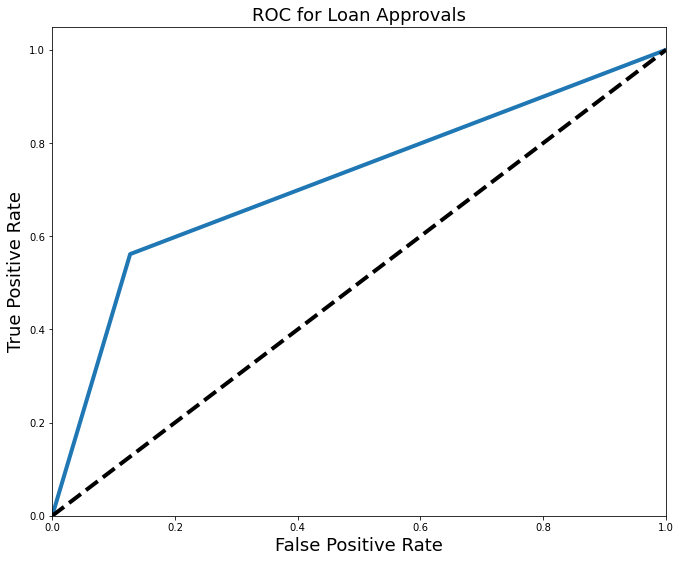

<AxesSubplot:xlabel='feature'>

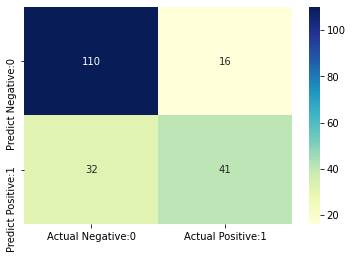

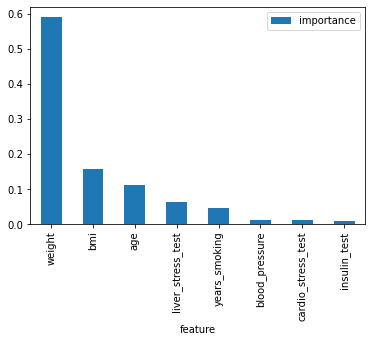

In [26]:
# 1) Accuracies 
acc_gbc = round(gbc.score(x_train, y_train) * 100, 2)
#print(round(acc_rfc,2,), "%")

acc_cv_gbc = cross_val_score(gbc, x_train, y_train, cv=10)
print(round(acc_cv_gbc.mean()), "%")
      
# 2) classification report
print(classification_report(y_test,y_prediction))

# 3)Area Under the curve
FPR, TPR, _ = roc_curve(y_test, y_prediction)
ROC_AUC = auc(FPR, TPR)
print (ROC_AUC)

#plot ROC_AUC
plt.figure(figsize =[11,9])
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 4)
plt.plot([0,1],[0,1], 'k--', linewidth = 4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('ROC for Loan Approvals', fontsize= 18)
plt.show()

# 4) Confusion matrix and plot
confusion_matrix = confusion_matrix(y_test, y_prediction)
cm_matrix = pd.DataFrame(data=confusion_matrix, columns=['Actual Negative:0', 'Actual Positive:1'], 
                                 index=['Predict Negative:0', 'Predict Positive:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# Feature Importance
importances = pd.DataFrame({'feature':x.columns,'importance':np.round(gbc.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

#plot 
importances.plot.bar()

### Building Simple ANN model

In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [28]:
# Initialising the ANN 
classifier = Sequential() 

classifier.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 8))
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
classifier.fit(x_train, y_train, batch_size = 1, epochs = 200)

Epoch 1/200
596/596 [==============================] - 13s 627us/step - loss: 0.6506 - accuracy: 0.6508
Epoch 2/200
596/596 [==============================] - 0s 784us/step - loss: 0.5234 - accuracy: 0.7422
Epoch 3/200
596/596 [==============================] - 1s 867us/step - loss: 0.4466 - accuracy: 0.7876
Epoch 4/200
596/596 [==============================] - 1s 864us/step - loss: 0.4644 - accuracy: 0.7605
Epoch 5/200
596/596 [==============================] - 1s 874us/step - loss: 0.4308 - accuracy: 0.7830
Epoch 6/200
596/596 [==============================] - 1s 939us/step - loss: 0.4347 - accuracy: 0.7843
Epoch 7/200
596/596 [==============================] - 1s 845us/step - loss: 0.4233 - accuracy: 0.7984
Epoch 8/200
596/596 [==============================] - 1s 887us/step - loss: 0.4357 - accuracy: 0.7776
Epoch 9/200
596/596 [==============================] - 1s 913us/step - loss: 0.3986 - accuracy: 0.81740s - loss: 0.3282 - 
Epoch 10/200
596/596 [==============================

596/596 [==============================] - 0s 771us/step - loss: 0.2837 - accuracy: 0.8808
Epoch 158/200
596/596 [==============================] - 0s 750us/step - loss: 0.3266 - accuracy: 0.8367
Epoch 159/200
596/596 [==============================] - 0s 779us/step - loss: 0.3522 - accuracy: 0.8280
Epoch 160/200
596/596 [==============================] - 0s 740us/step - loss: 0.2722 - accuracy: 0.8901
Epoch 161/200
596/596 [==============================] - 0s 783us/step - loss: 0.3454 - accuracy: 0.8488
Epoch 162/200
596/596 [==============================] - 0s 792us/step - loss: 0.3191 - accuracy: 0.8403
Epoch 163/200
596/596 [==============================] - 0s 808us/step - loss: 0.2915 - accuracy: 0.8572
Epoch 164/200
596/596 [==============================] - 0s 801us/step - loss: 0.2824 - accuracy: 0.8707
Epoch 165/200
596/596 [==============================] - 0s 792us/step - loss: 0.2989 - accuracy: 0.8617
Epoch 166/200
596/596 [==============================] - 0s 778us/ste

Our accuracy is 81.71428571428572%


<AxesSubplot:>

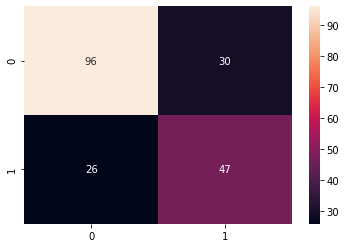

In [31]:
from sklearn.metrics import confusion_matrix

y_pred = classifier.predict(x_test)
y_pred = [ 1 if y>=0.5 else 0 for y in y_pred]

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print("Our accuracy is {}%".format(((cm[0][0] + cm[1][1])/175)*100))

sns.heatmap(cm, annot=True)

### ANN with Early Stopping

Train: 0.876, Test: 0.688


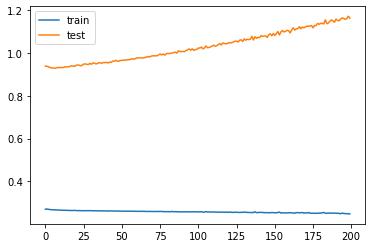

In [32]:
# simple early stopping
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
# fit model
history = classifier.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, verbose=0, callbacks=[es])
# evaluate the model
_, train_acc = classifier.evaluate(x_train, y_train, verbose=0)
_, test_acc = classifier.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Prediction for given 20 data points

In [34]:
prediction_dataset = pd.read_csv("2021-01-21_zeta-disease_prediction-data_dsi-take-home-challenge.csv")

In [35]:
x = pd.DataFrame.copy(prediction_dataset)
y = x.pop('zeta_disease')
print(x.shape, y.shape)

(20, 8) (20,)


In [36]:
# preprocessing of data. standardization
for feature in x.columns:
    std_scaler = StandardScaler()
    x[feature] = std_scaler.fit_transform(x[feature].values.reshape(-1,1))
x.head(10)

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking
0,-0.958114,-1.021011,0.776978,-0.695919,-0.986618,-0.769630,-0.629119,-0.605897
1,-0.690733,0.007345,0.157872,0.769174,0.147891,0.406194,-2.003665,-0.014778
2,-0.066845,-1.167919,-1.173206,-0.183137,-0.959605,0.562079,-0.946322,-1.197015
3,0.022282,0.998974,-0.321935,-0.402901,-0.243784,-0.484582,-0.100448,-0.014778
4,2.250454,0.521523,-0.724354,-1.208702,0.634109,0.936205,0.322490,0.871900
5,0.913551,-2.159547,0.312649,2.161013,-1.283751,-1.210564,-0.840588,1.758578
6,-1.314621,-1.461734,0.575769,-1.281957,-0.919087,0.054337,0.639693,-0.901456
7,-1.047241,-1.535188,-0.507667,-0.622665,-0.973111,-0.680553,-0.311916,0.280781
8,0.111409,0.594977,-0.616011,-1.428466,-0.054700,-0.533575,-0.311916,-0.014778
9,-1.403748,0.521523,-1.343460,0.402901,-1.067654,0.998560,-1.263525,-0.901456


In [37]:
# predicting with 20 data points
predictions = classifier.predict(x)
predictions = [ 1 if y>=0.5 else 0 for y in predictions]

In [38]:
predictions

[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1]

In [40]:
prediction_dataset['zeta_disease'] = predictions

In [42]:
# Save final predictions as csv file.
prediction_dataset.to_csv('final_predictions.csv', index=False) 

In [43]:
from keras.models import load_model
#Save trained ANN
classifier.save('zeta_disease_model.h5') 

## Conclusion

The accuracy of multiple models lies between 75-85% but the accuracy of Artifical Neural Network is high. Model is overfit with high variance as model highly trained. It is due to very less data. If we have more data then we can limit the variance and also we can increase the accuracy.   

  =================================== Thank you ======================================